<a href="https://colab.research.google.com/github/hyewwn/2023-summer-internship-DSAIL/blob/main/GraphSAGE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset & packages load

## download packages

In [1]:
!pip install torch==2.0.0
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: torc

## import packages

In [2]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [3]:
torch.manual_seed(1)

## load dataset (Cora)

In [4]:
dataset = Planetoid(root='tmp/Cora', name='Cora')

Processing...
Done!


## dataset info

In [5]:
print(len(dataset)) # 데이터셋 전체가 하나의 그래프
print(dataset.num_classes) # class 수 = 7
print(dataset.num_node_features) # 1433개의 노드 특성 (하나의 노드에 1433개의 값이 존재)

1
7
1433


In [6]:
data = dataset[0]

In [7]:
data
# 2708개의 노드 1433개의 노드 특성
# 10556개의 엣지

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
print(data.is_undirected()) # 양방향 그래프

True


In [9]:
data.train_mask.sum().item() # 학습하기 위해 사용하는 노드 수

140

In [10]:
data.val_mask.sum().item() # 검증 시 사용하는 노드 수

500

In [11]:
data.test_mask.sum().item() #테스트 시 사용하는 노드 수

1000

In [12]:
data.num_edges

10556

# Neighborhood sampling & Batch creation

In [13]:
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors = [25, 10], # same as paper
    batch_size = 40,
    input_nodes = data.train_mask
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [14]:
# Print each subgraph
for i, subgraph in enumerate(train_loader):
  print(f'subgraph {i}: {subgraph}')

subgraph 0: Data(x=[500, 1433], edge_index=[2, 817], y=[500], train_mask=[500], val_mask=[500], test_mask=[500], n_id=[500], e_id=[817], input_id=[40], batch_size=40)
subgraph 1: Data(x=[563, 1433], edge_index=[2, 918], y=[563], train_mask=[563], val_mask=[563], test_mask=[563], n_id=[563], e_id=[918], input_id=[40], batch_size=40)
subgraph 2: Data(x=[688, 1433], edge_index=[2, 1324], y=[688], train_mask=[688], val_mask=[688], test_mask=[688], n_id=[688], e_id=[1324], input_id=[40], batch_size=40)
subgraph 3: Data(x=[230, 1433], edge_index=[2, 414], y=[230], train_mask=[230], val_mask=[230], test_mask=[230], n_id=[230], e_id=[414], input_id=[20], batch_size=20)


## batch graph check

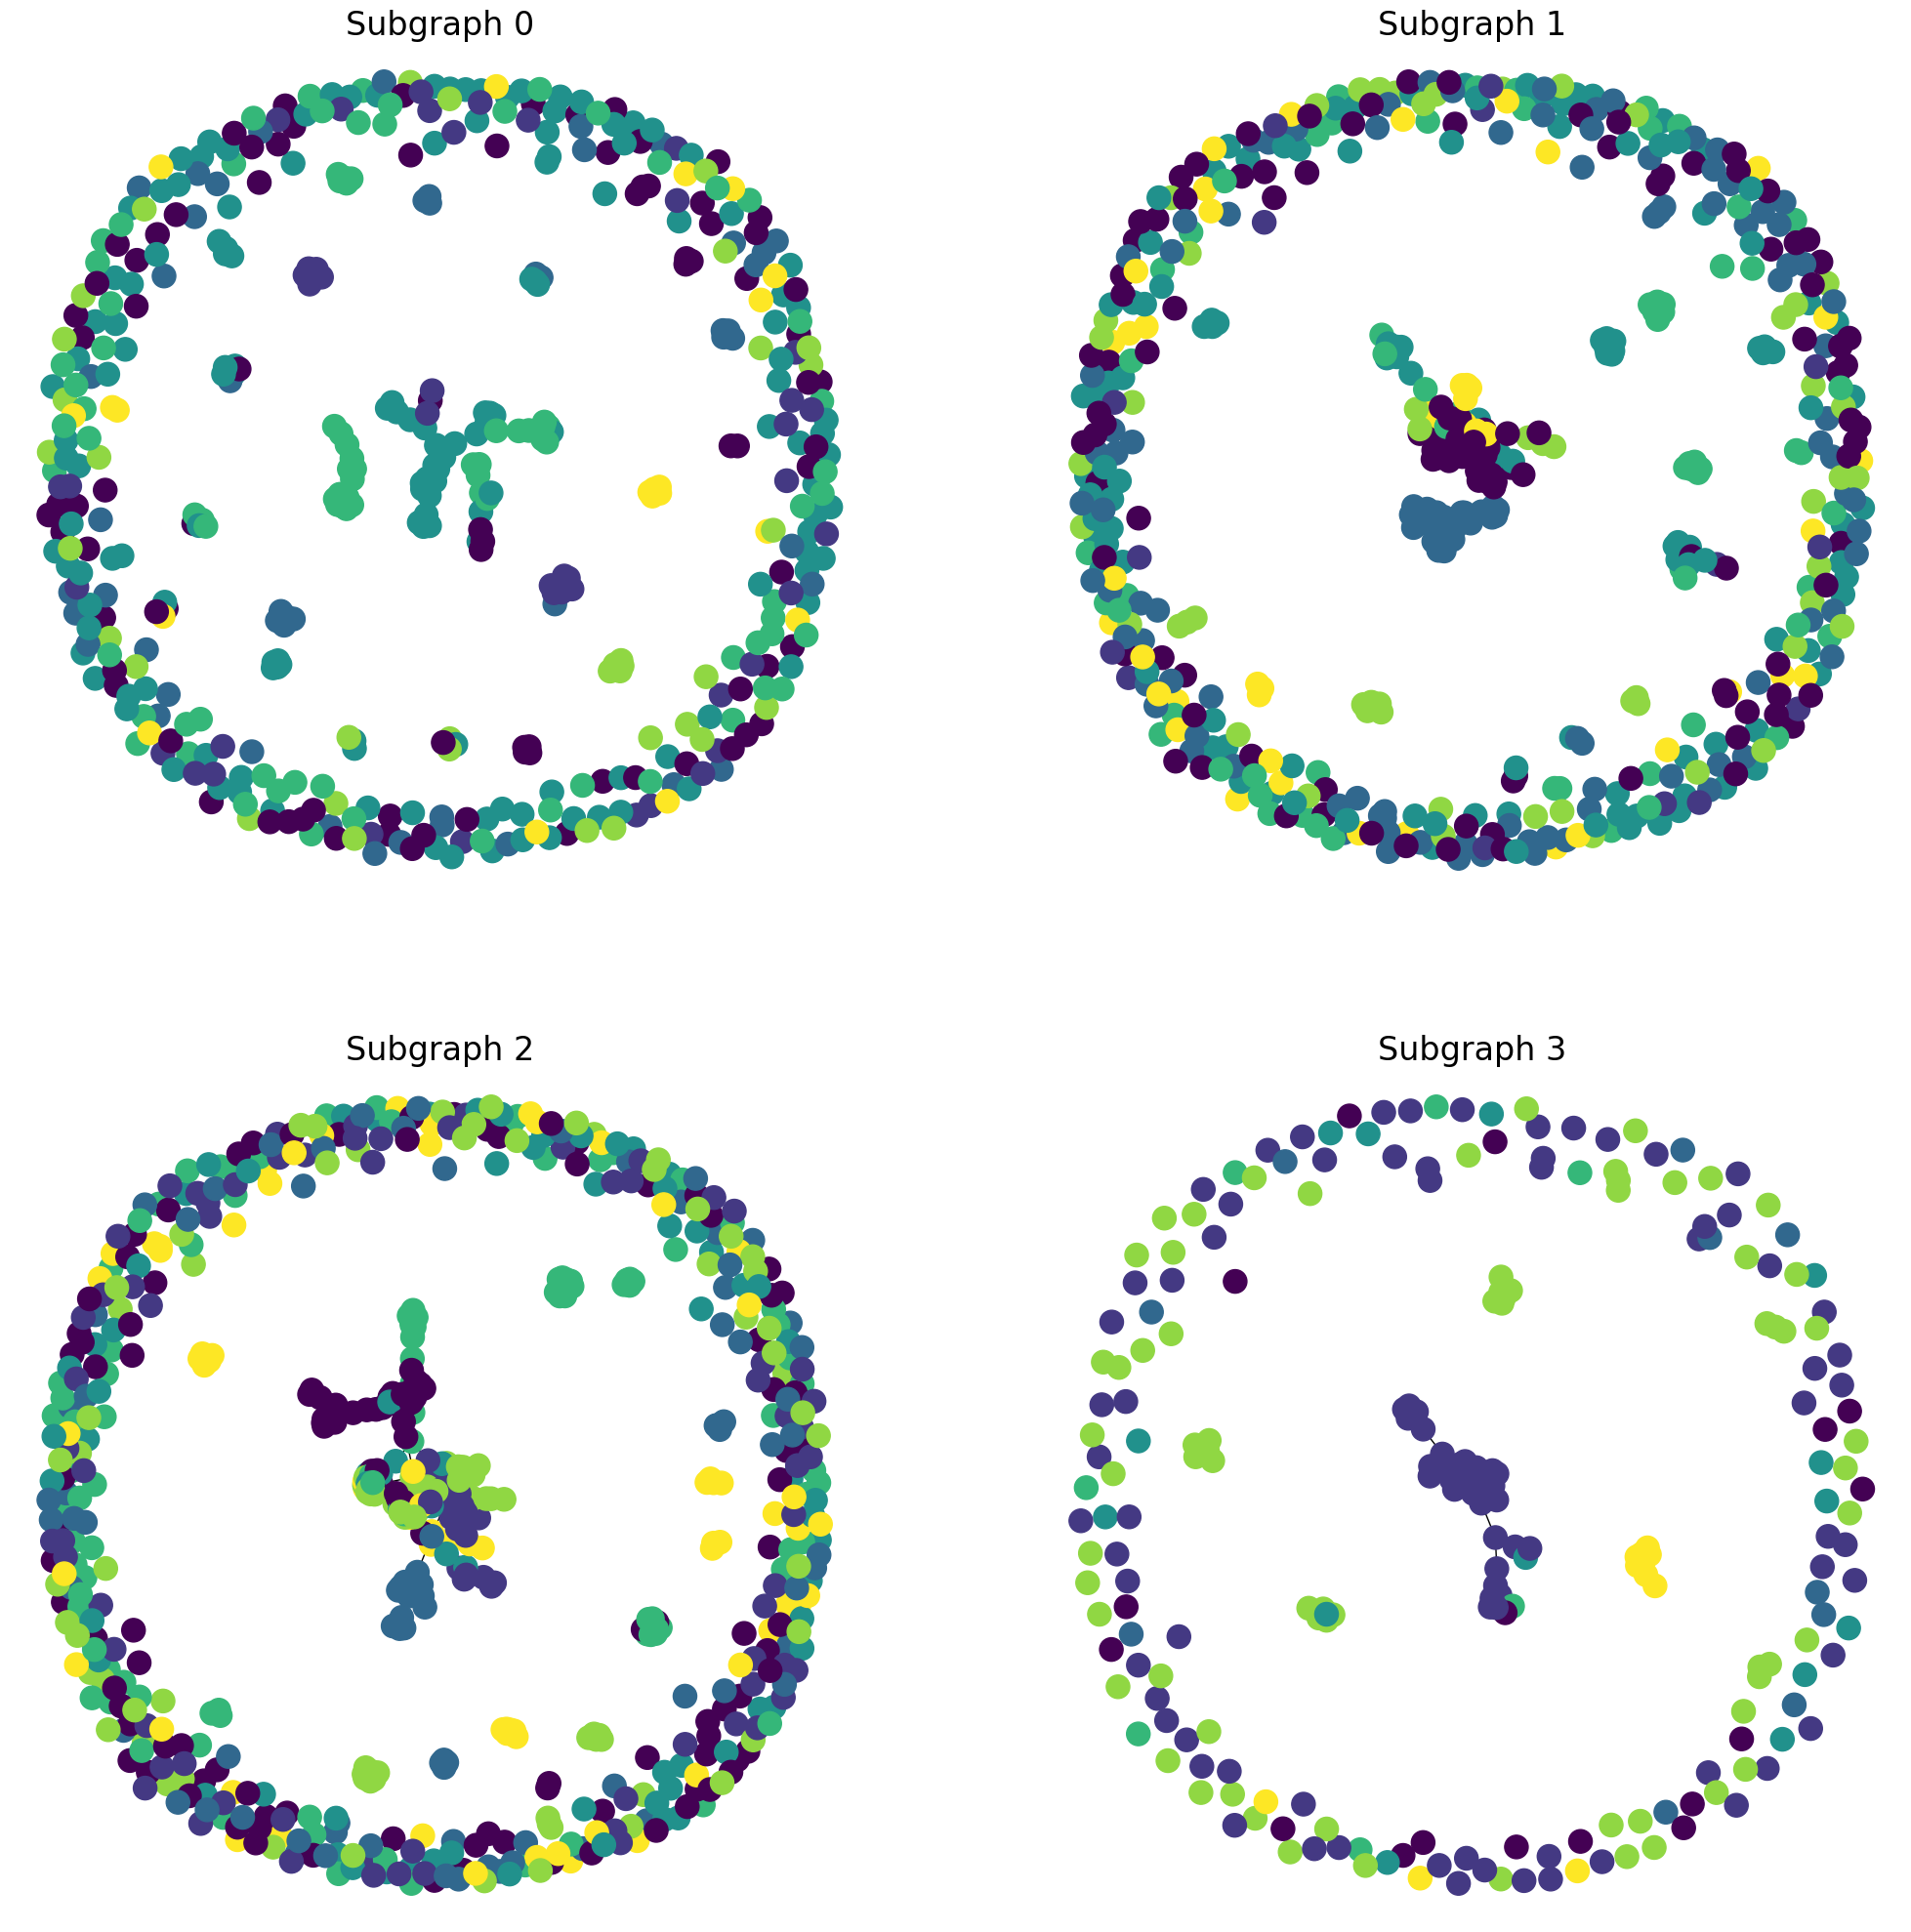

In [15]:
# plot each subgraph
fig = plt.figure(figsize=(25,25))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
  G = to_networkx(subdata, to_undirected=True)
  ax = fig.add_subplot(pos)
  ax.set_title(f'Subgraph {idx}', fontsize = 24)
  plt.axis('off')
  nx.draw(G,
          pos=nx.spring_layout(G, seed=0),
          with_labels=False,
          node_color=subdata.y)

plt.show()

## degree check

In [16]:
from torch_geometric.utils import degree
from collections import Counter

In [17]:
def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(18,6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='skyblue')


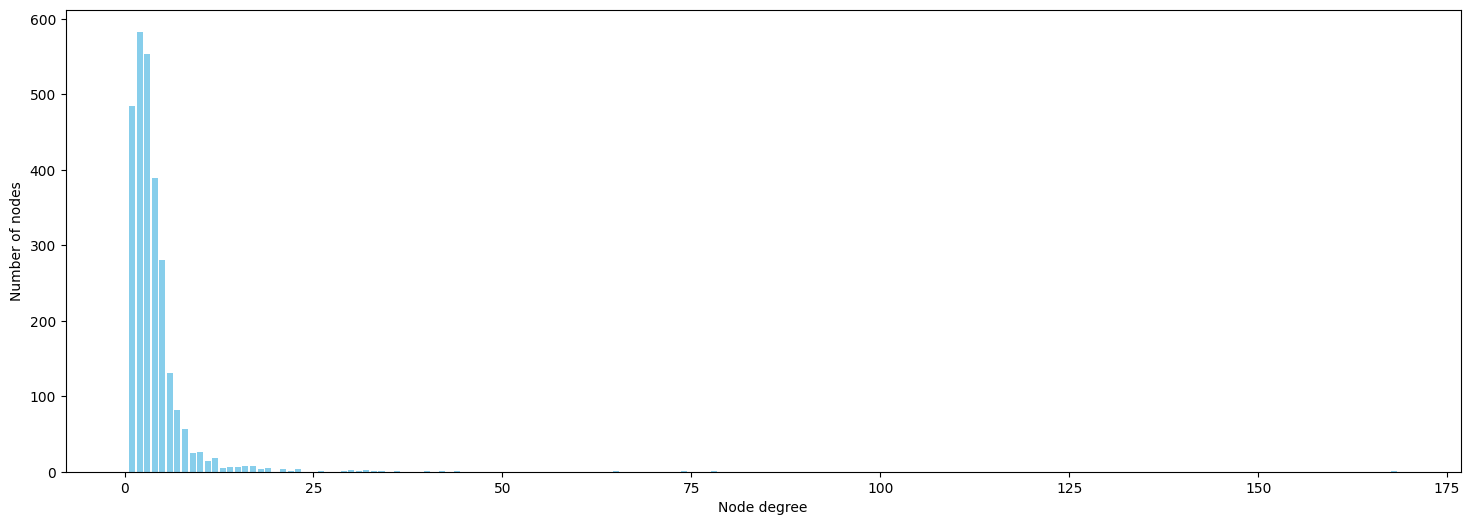

In [18]:
# plot node degrees from the original graph
plot_degree(data)

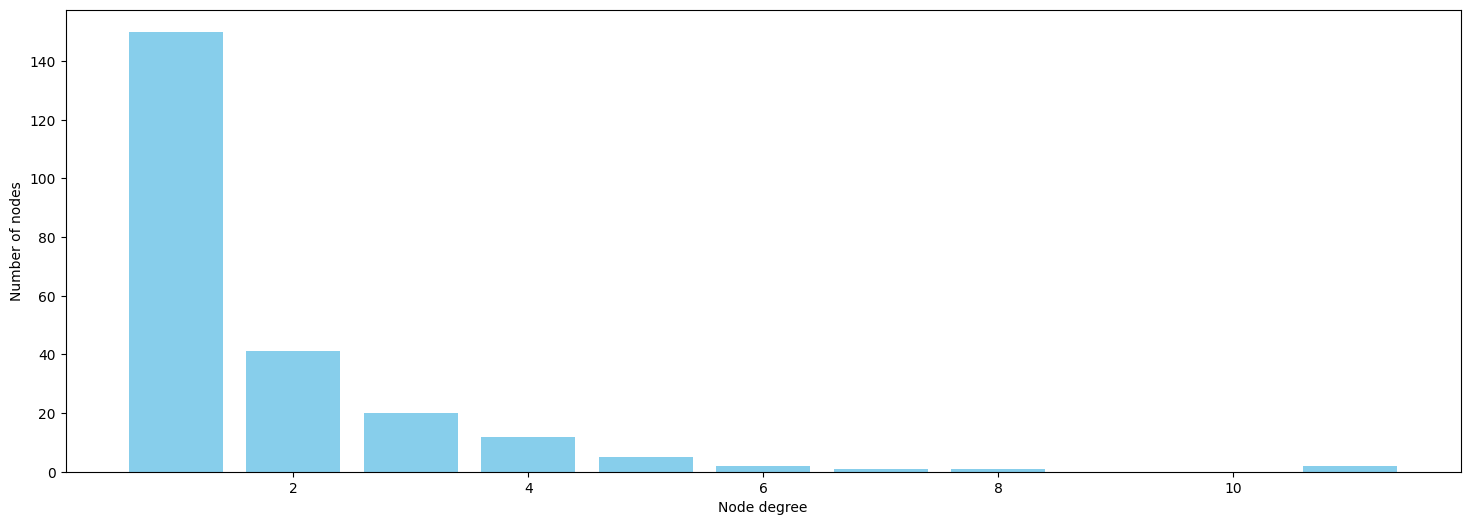

In [19]:
# plot node degrees from the last subgraph
plot_degree(subdata)

# Functions

## accuracy calculation

In [20]:
def accuracy(pred_y, y):
  return((pred_y == y).sum()/len(y)).item()

## GraphSAGE

In [21]:
class GraphSAGE(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, agg = 'mean'):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h, aggr=agg)
    self.sage2 = SAGEConv(dim_h, dim_out, aggr=agg)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim= 1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss.item()
        acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if epoch % 5 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f}'
              f'| Train Acc: {acc/len(train_loader)*100:>6.2f}%'
              f'| Val Loss: {val_loss/len(train_loader):.2f}'
              f'| Val Acc: {val_acc/len(train_loader)*100:.2f}%')

  @torch.no_grad()
  def test(self, data):
    test_acc = 0
    self.eval()

    for batch in train_loader:
      out = self(batch.x, batch.edge_index)
      test_acc += accuracy(out[batch.test_mask].argmax(dim=1), batch.y[batch.test_mask])

    print(f'GraphSAGE test accuracy: {test_acc/len(train_loader)*100:.2f}%')

# Experiment

## Default Setting

### mean

In [22]:
exp1_mean_small = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(exp1_mean_small)

# Train
exp1_mean_small.fit(data, 30)

# Test
exp1_mean_small.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=mean)
  (sage2): SAGEConv(64, 7, aggr=mean)
)
Epoch   0 | Train Loss: 0.432| Train Acc:  27.43%| Val Loss: 1.95| Val Acc: 15.68%
Epoch   5 | Train Loss: 0.007| Train Acc: 100.00%| Val Loss: 1.15| Val Acc: 59.09%
Epoch  10 | Train Loss: 0.001| Train Acc: 100.00%| Val Loss: 1.17| Val Acc: 64.75%
Epoch  15 | Train Loss: 0.002| Train Acc: 100.00%| Val Loss: 1.19| Val Acc: 61.62%
Epoch  20 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.16| Val Acc: 62.73%
Epoch  25 | Train Loss: 0.001| Train Acc:  99.59%| Val Loss: 1.18| Val Acc: 59.92%
Epoch  30 | Train Loss: 0.001| Train Acc: 100.00%| Val Loss: 1.31| Val Acc: 58.25%
GraphSAGE test accuracy: 65.85%


In [23]:
exp1_mean_big = GraphSAGE(dataset.num_features, 256, dataset.num_classes)
print(exp1_mean_big)

# Train
exp1_mean_big.fit(data, 30)

# Test
exp1_mean_big.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 256, aggr=mean)
  (sage2): SAGEConv(256, 7, aggr=mean)
)
Epoch   0 | Train Loss: 0.399| Train Acc:  34.53%| Val Loss: 1.92| Val Acc: 20.41%
Epoch   5 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.12| Val Acc: 65.92%
Epoch  10 | Train Loss: 0.000| Train Acc:  99.65%| Val Loss: 1.09| Val Acc: 69.28%
Epoch  15 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.13| Val Acc: 60.68%
Epoch  20 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.06| Val Acc: 65.69%
Epoch  25 | Train Loss: 0.001| Train Acc: 100.00%| Val Loss: 1.05| Val Acc: 63.57%
Epoch  30 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.03| Val Acc: 63.91%
GraphSAGE test accuracy: 65.86%


### lstm

In [24]:
exp1_lstm_small = GraphSAGE(dataset.num_features, 64, dataset.num_classes, agg='lstm')
print(exp1_lstm_small)

# Train
exp1_lstm_small.fit(data, 30)

# Test
exp1_lstm_small.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=lstm)
  (sage2): SAGEConv(64, 7, aggr=lstm)
)
Epoch   0 | Train Loss: 0.723| Train Acc:  14.02%| Val Loss: 2.38| Val Acc: 14.01%
Epoch   5 | Train Loss: 0.304| Train Acc:  44.35%| Val Loss: 1.92| Val Acc: 24.26%
Epoch  10 | Train Loss: 0.100| Train Acc:  87.42%| Val Loss: 1.67| Val Acc: 36.56%
Epoch  15 | Train Loss: 0.014| Train Acc:  94.41%| Val Loss: 1.69| Val Acc: 40.85%
Epoch  20 | Train Loss: 0.006| Train Acc:  95.62%| Val Loss: 1.66| Val Acc: 48.65%
Epoch  25 | Train Loss: 0.031| Train Acc:  95.16%| Val Loss: 1.67| Val Acc: 49.47%
Epoch  30 | Train Loss: 0.030| Train Acc:  96.44%| Val Loss: 1.65| Val Acc: 50.06%
GraphSAGE test accuracy: 59.27%


In [25]:
exp1_lstm_big = GraphSAGE(dataset.num_features, 256, dataset.num_classes, agg='lstm')
print(exp1_lstm_big)

# Train
exp1_lstm_big.fit(data, 30)

# Test
exp1_lstm_big.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 256, aggr=lstm)
  (sage2): SAGEConv(256, 7, aggr=lstm)
)
Epoch   0 | Train Loss: 0.766| Train Acc:  13.53%| Val Loss: 2.36| Val Acc: 13.86%
Epoch   5 | Train Loss: 0.063| Train Acc:  93.10%| Val Loss: 1.44| Val Acc: 47.21%
Epoch  10 | Train Loss: 0.003| Train Acc:  99.56%| Val Loss: 1.43| Val Acc: 51.51%
Epoch  15 | Train Loss: 0.002| Train Acc: 100.00%| Val Loss: 1.51| Val Acc: 52.62%
Epoch  20 | Train Loss: 0.003| Train Acc: 100.00%| Val Loss: 1.56| Val Acc: 53.21%
Epoch  25 | Train Loss: 0.002| Train Acc: 100.00%| Val Loss: 1.46| Val Acc: 53.10%
Epoch  30 | Train Loss: 0.001| Train Acc: 100.00%| Val Loss: 1.42| Val Acc: 52.53%
GraphSAGE test accuracy: 64.00%


### max

In [26]:
exp1_max_small = GraphSAGE(dataset.num_features, 64, dataset.num_classes, agg='max')
print(exp1_max_small)

# Train
exp1_max_small.fit(data, 30)

# Test
exp1_max_small.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=max)
  (sage2): SAGEConv(64, 7, aggr=max)
)
Epoch   0 | Train Loss: 0.349| Train Acc:  31.62%| Val Loss: 1.95| Val Acc: 17.74%
Epoch   5 | Train Loss: 0.009| Train Acc:  99.64%| Val Loss: 1.41| Val Acc: 51.41%
Epoch  10 | Train Loss: 0.001| Train Acc:  99.58%| Val Loss: 1.53| Val Acc: 54.61%
Epoch  15 | Train Loss: 0.003| Train Acc: 100.00%| Val Loss: 1.46| Val Acc: 52.28%
Epoch  20 | Train Loss: 0.020| Train Acc:  98.80%| Val Loss: 1.51| Val Acc: 55.67%
Epoch  25 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.33| Val Acc: 56.47%
Epoch  30 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.30| Val Acc: 56.89%
GraphSAGE test accuracy: 63.44%


In [27]:
exp1_max_big = GraphSAGE(dataset.num_features, 256, dataset.num_classes, agg='max')
print(exp1_max_big)

# Train
exp1_max_big.fit(data, 30)

# Test
exp1_max_big.test(data)

GraphSAGE(
  (sage1): SAGEConv(1433, 256, aggr=max)
  (sage2): SAGEConv(256, 7, aggr=max)
)
Epoch   0 | Train Loss: 0.284| Train Acc:  35.78%| Val Loss: 2.00| Val Acc: 21.50%
Epoch   5 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.20| Val Acc: 61.52%
Epoch  10 | Train Loss: 0.000| Train Acc:  99.60%| Val Loss: 1.38| Val Acc: 61.04%
Epoch  15 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.23| Val Acc: 62.53%
Epoch  20 | Train Loss: 0.001| Train Acc: 100.00%| Val Loss: 1.06| Val Acc: 65.26%
Epoch  25 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.10| Val Acc: 65.59%
Epoch  30 | Train Loss: 0.000| Train Acc: 100.00%| Val Loss: 1.08| Val Acc: 64.91%
GraphSAGE test accuracy: 62.90%
